Mount Drive

In [1]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


setting project workspace

In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/EVA4/S9')

In [16]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/EVA4/S9/*

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/datasetloader.py'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/README.md'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/S9_Assignment.ipynb'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/train_test.py'
'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/utils.py'

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/gradcam':
gradcam.py  __init__.py  __pycache__  utils.py

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/models':
depthwise_separable_conv2d.py  __pycache__  QuizDNN.py	resnet.py

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/__pycache__':
datasetloader.cpython-36.pyc  train_test.cpython-36.pyc  utils.cpython-36.pyc

'/content/gdrive/My Drive/Colab Notebooks/EVA4/S9/transform':
albu_transforms.py  __init__.py  __pycache__  pytorch_transforms.py


Import Libraries

In [4]:
!pip install albumentations==0.4.5

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
#import torchvision.transforms as transforms
from torchsummary import summary
from tqdm import tqdm
import torch.backends.cudnn as cudnn

from transform.albu_transforms import *
import datasetloader as d
from models.resnet import *
from train_test import train, test


Loading data

In [0]:
# This is already available in albu_transforms.py. For quick experimentation, added here.
#from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize, Cutout, Rotate, GaussianBlur, VerticalFlip
#from albumentations.pytorch import ToTensor, ToTensorV2
#import numpy as np


# Albumentations Transformations
#transform_train_albu = Compose([
#    RandomCrop(height=32, width=32), #, always_apply=True 
#    HorizontalFlip(p=0.2),
#    VerticalFlip(p=0.0),
#    GaussianBlur(p=0.0),
#    Rotate(limit=20),
#    #ToTensor(),
#    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010), always_apply=True),
#    Cutout(num_holes=1, max_h_size=8, max_w_size=8, fill_value=[0.4914, 0.4822, 0.4465], p=0.3),
#    ToTensorV2(always_apply=True)
#])


#transform_test_albu = Compose([
#    #ToTensor(),
#    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
#    ToTensorV2(always_apply=True)
#])

#transform_test_albu = AlbuCompose(transform_test_albu)
#transform_train_albu = AlbuCompose(transform_train_albu)

In [7]:
# setting up random seed and processing device
SEED = 1
cuda = torch.cuda.is_available()
if cuda:
    device = "cuda"
    torch.cuda.manual_seed(SEED)
else:
    device = "cpu"
    torch.manual_seed(SEED)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## getting training data loader
trainloader = d.get_dataloader_CIFAR10(True, cuda, transform=transform_train_albu)

## getting test data loader
testloader = d.get_dataloader_CIFAR10(False, cuda, transform=transform_test_albu)


Files already downloaded and verified
Files already downloaded and verified


initializing network architecture

In [8]:
!pip install torchsummary
from torchsummary import summary
net = ResNet18()
net = net.to(device)
if cuda:
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

Model training and Evaluation

In [9]:
# loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

# Model Training and Evaluation
for epoch in range(0, 100):
    train(net, device, trainloader, optimizer, epoch, criterion)
    test(net, device, testloader, criterion)


epoch=0 Loss=0.9389305114746094 Batch_id=390 Accuracy=43.31: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0099, Accuracy: 5414/10000 (54.1%)



epoch=1 Loss=1.1603031158447266 Batch_id=390 Accuracy=58.92: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0085, Accuracy: 6103/10000 (61.0%)



epoch=2 Loss=0.9229801297187805 Batch_id=390 Accuracy=66.67: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6812/10000 (68.1%)



epoch=3 Loss=0.735445499420166 Batch_id=390 Accuracy=71.32: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0063, Accuracy: 7155/10000 (71.5%)



epoch=4 Loss=0.8941019177436829 Batch_id=390 Accuracy=75.15: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 7295/10000 (73.0%)



epoch=5 Loss=0.6842025518417358 Batch_id=390 Accuracy=77.88: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7626/10000 (76.3%)



epoch=6 Loss=0.7095961570739746 Batch_id=390 Accuracy=80.72: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 7661/10000 (76.6%)



epoch=7 Loss=0.3101544976234436 Batch_id=390 Accuracy=82.42: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0058, Accuracy: 7592/10000 (75.9%)



epoch=8 Loss=0.4384307861328125 Batch_id=390 Accuracy=83.98: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7798/10000 (78.0%)



epoch=9 Loss=0.4463345408439636 Batch_id=390 Accuracy=85.50: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8098/10000 (81.0%)



epoch=10 Loss=0.3806929290294647 Batch_id=390 Accuracy=86.82: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 7957/10000 (79.6%)



epoch=11 Loss=0.2667882442474365 Batch_id=390 Accuracy=87.48: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7880/10000 (78.8%)



epoch=12 Loss=0.34100788831710815 Batch_id=390 Accuracy=88.66: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 7872/10000 (78.7%)



epoch=13 Loss=0.3491019308567047 Batch_id=390 Accuracy=89.72: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8167/10000 (81.7%)



epoch=14 Loss=0.3591260612010956 Batch_id=390 Accuracy=90.46: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8165/10000 (81.7%)



epoch=15 Loss=0.2316831797361374 Batch_id=390 Accuracy=91.12: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8230/10000 (82.3%)



epoch=16 Loss=0.32109081745147705 Batch_id=390 Accuracy=91.71: 100%|██████████| 391/391 [00:39<00:00,  9.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8290/10000 (82.9%)



epoch=17 Loss=0.25027742981910706 Batch_id=390 Accuracy=92.28: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8158/10000 (81.6%)



epoch=18 Loss=0.37624239921569824 Batch_id=390 Accuracy=92.43: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8300/10000 (83.0%)



epoch=19 Loss=0.2612602114677429 Batch_id=390 Accuracy=92.94: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8359/10000 (83.6%)



epoch=20 Loss=0.1911344975233078 Batch_id=390 Accuracy=93.50: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8217/10000 (82.2%)



epoch=21 Loss=0.3284999430179596 Batch_id=390 Accuracy=93.80: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8369/10000 (83.7%)



epoch=22 Loss=0.18299320340156555 Batch_id=390 Accuracy=94.33: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8360/10000 (83.6%)



epoch=23 Loss=0.19558924436569214 Batch_id=390 Accuracy=94.48: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8360/10000 (83.6%)



epoch=24 Loss=0.07798826694488525 Batch_id=390 Accuracy=94.75: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8399/10000 (84.0%)



epoch=25 Loss=0.12002407014369965 Batch_id=390 Accuracy=94.84: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8320/10000 (83.2%)



epoch=26 Loss=0.1395745575428009 Batch_id=390 Accuracy=95.23: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8464/10000 (84.6%)



epoch=27 Loss=0.2621825337409973 Batch_id=390 Accuracy=95.39: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 8289/10000 (82.9%)



epoch=28 Loss=0.19010691344738007 Batch_id=390 Accuracy=95.57: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8489/10000 (84.9%)



epoch=29 Loss=0.1054387241601944 Batch_id=390 Accuracy=95.78: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8405/10000 (84.0%)



epoch=30 Loss=0.1688666045665741 Batch_id=390 Accuracy=95.97: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8536/10000 (85.4%)



epoch=31 Loss=0.11337021738290787 Batch_id=390 Accuracy=95.90: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 8350/10000 (83.5%)



epoch=32 Loss=0.11052463203668594 Batch_id=390 Accuracy=96.14: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 8376/10000 (83.8%)



epoch=33 Loss=0.17102280259132385 Batch_id=390 Accuracy=96.44: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8531/10000 (85.3%)



epoch=34 Loss=0.11647109687328339 Batch_id=390 Accuracy=96.45: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8465/10000 (84.7%)



epoch=35 Loss=0.02430235780775547 Batch_id=390 Accuracy=96.71: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8521/10000 (85.2%)



epoch=36 Loss=0.06613984704017639 Batch_id=390 Accuracy=96.61: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8508/10000 (85.1%)



epoch=37 Loss=0.02200155332684517 Batch_id=390 Accuracy=96.71: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8536/10000 (85.4%)



epoch=38 Loss=0.06264299154281616 Batch_id=390 Accuracy=96.76: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8603/10000 (86.0%)



epoch=39 Loss=0.11293653398752213 Batch_id=390 Accuracy=96.90: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8597/10000 (86.0%)



epoch=40 Loss=0.030041545629501343 Batch_id=390 Accuracy=97.03: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8517/10000 (85.2%)



epoch=41 Loss=0.06525759398937225 Batch_id=390 Accuracy=97.24: 100%|██████████| 391/391 [00:39<00:00,  9.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8487/10000 (84.9%)



epoch=42 Loss=0.0825430303812027 Batch_id=390 Accuracy=97.28: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8546/10000 (85.5%)



epoch=43 Loss=0.1559307873249054 Batch_id=390 Accuracy=97.28: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8501/10000 (85.0%)



epoch=44 Loss=0.052561599761247635 Batch_id=390 Accuracy=97.38: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8546/10000 (85.5%)



epoch=45 Loss=0.06985722482204437 Batch_id=390 Accuracy=97.62: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8565/10000 (85.7%)



epoch=46 Loss=0.09874431788921356 Batch_id=390 Accuracy=97.47: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8626/10000 (86.3%)



epoch=47 Loss=0.0814945250749588 Batch_id=390 Accuracy=97.57: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8592/10000 (85.9%)



epoch=48 Loss=0.04243836551904678 Batch_id=390 Accuracy=97.68: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8640/10000 (86.4%)



epoch=49 Loss=0.033484093844890594 Batch_id=390 Accuracy=97.59: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8617/10000 (86.2%)



epoch=50 Loss=0.12296702712774277 Batch_id=390 Accuracy=98.00: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8585/10000 (85.8%)



epoch=51 Loss=0.049494244158267975 Batch_id=390 Accuracy=97.77: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8681/10000 (86.8%)



epoch=52 Loss=0.08404236286878586 Batch_id=390 Accuracy=97.95: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8633/10000 (86.3%)



epoch=53 Loss=0.10823418945074081 Batch_id=390 Accuracy=97.85: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8647/10000 (86.5%)



epoch=54 Loss=0.04146644473075867 Batch_id=390 Accuracy=97.85: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8636/10000 (86.4%)



epoch=55 Loss=0.03959730640053749 Batch_id=390 Accuracy=98.04: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8650/10000 (86.5%)



epoch=56 Loss=0.018409479409456253 Batch_id=390 Accuracy=98.24: 100%|██████████| 391/391 [00:39<00:00,  9.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8575/10000 (85.8%)



epoch=57 Loss=0.06302221119403839 Batch_id=390 Accuracy=98.06: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8683/10000 (86.8%)



epoch=58 Loss=0.08813508599996567 Batch_id=390 Accuracy=98.06: 100%|██████████| 391/391 [00:39<00:00,  9.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8696/10000 (87.0%)



epoch=59 Loss=0.06968678534030914 Batch_id=390 Accuracy=98.17: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8671/10000 (86.7%)



epoch=60 Loss=0.0976901575922966 Batch_id=390 Accuracy=98.23: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8714/10000 (87.1%)



epoch=61 Loss=0.13905617594718933 Batch_id=390 Accuracy=98.18: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8669/10000 (86.7%)



epoch=62 Loss=0.026307523250579834 Batch_id=390 Accuracy=98.33: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8706/10000 (87.1%)



epoch=63 Loss=0.007196462247520685 Batch_id=390 Accuracy=98.33: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8619/10000 (86.2%)



epoch=64 Loss=0.025369863957166672 Batch_id=390 Accuracy=98.30: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8688/10000 (86.9%)



epoch=65 Loss=0.06476463377475739 Batch_id=390 Accuracy=98.41: 100%|██████████| 391/391 [00:39<00:00,  9.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8668/10000 (86.7%)



epoch=66 Loss=0.023133913055062294 Batch_id=390 Accuracy=98.33: 100%|██████████| 391/391 [00:39<00:00,  9.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8714/10000 (87.1%)



epoch=67 Loss=0.06461133062839508 Batch_id=390 Accuracy=98.48: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8684/10000 (86.8%)



epoch=68 Loss=0.015988629311323166 Batch_id=390 Accuracy=98.47: 100%|██████████| 391/391 [00:39<00:00,  9.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8690/10000 (86.9%)



epoch=69 Loss=0.0433465950191021 Batch_id=390 Accuracy=98.36: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8657/10000 (86.6%)



epoch=70 Loss=0.007488560862839222 Batch_id=390 Accuracy=98.49: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8718/10000 (87.2%)



epoch=71 Loss=0.057330042123794556 Batch_id=390 Accuracy=98.64: 100%|██████████| 391/391 [00:39<00:00,  9.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8673/10000 (86.7%)



epoch=72 Loss=0.03179047629237175 Batch_id=390 Accuracy=98.45: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8669/10000 (86.7%)



epoch=73 Loss=0.045972395688295364 Batch_id=390 Accuracy=98.55: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8745/10000 (87.5%)



epoch=74 Loss=0.014850527048110962 Batch_id=390 Accuracy=98.50: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8751/10000 (87.5%)



epoch=75 Loss=0.030992990359663963 Batch_id=390 Accuracy=98.68: 100%|██████████| 391/391 [00:39<00:00,  9.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 8630/10000 (86.3%)



epoch=76 Loss=0.07135464251041412 Batch_id=390 Accuracy=98.59: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8728/10000 (87.3%)



epoch=77 Loss=0.008691960945725441 Batch_id=390 Accuracy=98.68: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8723/10000 (87.2%)



epoch=78 Loss=0.0935322493314743 Batch_id=390 Accuracy=98.78: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8768/10000 (87.7%)



epoch=79 Loss=0.04051690548658371 Batch_id=390 Accuracy=98.80: 100%|██████████| 391/391 [00:39<00:00,  9.94it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8720/10000 (87.2%)



epoch=80 Loss=0.02234632894396782 Batch_id=390 Accuracy=98.72: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8774/10000 (87.7%)



epoch=81 Loss=0.07193144410848618 Batch_id=390 Accuracy=98.85: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8753/10000 (87.5%)



epoch=82 Loss=0.015209972858428955 Batch_id=390 Accuracy=98.80: 100%|██████████| 391/391 [00:39<00:00,  9.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8771/10000 (87.7%)



epoch=83 Loss=0.014683062210679054 Batch_id=390 Accuracy=98.82: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8708/10000 (87.1%)



epoch=84 Loss=0.046045683324337006 Batch_id=390 Accuracy=98.83: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8742/10000 (87.4%)



epoch=85 Loss=0.04683954641222954 Batch_id=390 Accuracy=98.80: 100%|██████████| 391/391 [00:39<00:00,  9.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8695/10000 (87.0%)



epoch=86 Loss=0.03024301491677761 Batch_id=390 Accuracy=98.83: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8709/10000 (87.1%)



epoch=87 Loss=0.02111092209815979 Batch_id=390 Accuracy=98.87: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8752/10000 (87.5%)



epoch=88 Loss=0.01801462098956108 Batch_id=390 Accuracy=98.90: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8750/10000 (87.5%)



epoch=89 Loss=0.0166582353413105 Batch_id=390 Accuracy=98.96: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8728/10000 (87.3%)



epoch=90 Loss=0.17900486290454865 Batch_id=390 Accuracy=98.97: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8764/10000 (87.6%)



epoch=91 Loss=0.05509012192487717 Batch_id=390 Accuracy=98.97: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 8740/10000 (87.4%)



epoch=92 Loss=0.00601086625829339 Batch_id=390 Accuracy=98.84: 100%|██████████| 391/391 [00:39<00:00,  9.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8807/10000 (88.1%)



epoch=93 Loss=0.03189064562320709 Batch_id=390 Accuracy=98.93: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8742/10000 (87.4%)



epoch=94 Loss=0.061897195875644684 Batch_id=390 Accuracy=98.99: 100%|██████████| 391/391 [00:39<00:00,  9.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8748/10000 (87.5%)



epoch=95 Loss=0.05833771824836731 Batch_id=390 Accuracy=98.95: 100%|██████████| 391/391 [00:39<00:00,  9.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8797/10000 (88.0%)



epoch=96 Loss=0.04075491428375244 Batch_id=390 Accuracy=99.01: 100%|██████████| 391/391 [00:39<00:00,  9.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8787/10000 (87.9%)



epoch=97 Loss=0.01622055098414421 Batch_id=390 Accuracy=98.89: 100%|██████████| 391/391 [00:39<00:00,  9.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8793/10000 (87.9%)



epoch=98 Loss=0.015032118186354637 Batch_id=390 Accuracy=99.05: 100%|██████████| 391/391 [00:39<00:00,  9.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8810/10000 (88.1%)



epoch=99 Loss=0.033839013427495956 Batch_id=390 Accuracy=99.10: 100%|██████████| 391/391 [00:39<00:00,  9.89it/s]



Test set: Average loss: 0.0040, Accuracy: 8760/10000 (87.6%)



## Test the GridCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  cat  bird truck   car


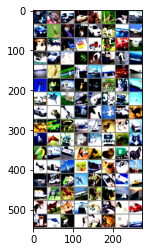

In [11]:
from utils import *
# Let's visualize some of the images
# get some random training images
dataiter = iter(trainloader)
images_orig, labels = dataiter.next()
# show images
imshow(torchvision.utils.make_grid(images_orig))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**Show the actual image and GridCAM**

In [0]:
# This function is available in utils. For testing added here.
def plot_cam(img, mean, sd, device):
    """
    Plots the cam
    """
    # convert to PIL
    pil_img = F.to_pil_image(img)

    # normed_torch_img = transform_test_albu(pil_img).to(device)

    # call the transformation. To keep it simple, we are calling PyTorch way of transform
    torch_img = transforms.Compose([
        transforms.ToTensor()
    ])(pil_img).to(device)
    normed_torch_img = transforms.Normalize(mean=mean, std=sd)(torch_img)[None]

    # Call the GridCAM
    config = dict(model_type='resnet', arch=net, layer_name='layer4')
    gradcam = GradCAM.from_config(**config)

    images = []

    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    images.extend([torch_img.cpu(), heatmap, result])

    grid_image = make_grid(images, nrow=5)

    return transforms.ToPILImage()(grid_image)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


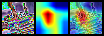

In [19]:
mean = (0.4914, 0.4822, 0.4465)
sd = (0.2023, 0.1994, 0.2010)

# get one image to test
image_test = images_orig[3]
plot_cam(image_test, mean=mean, sd=sd, device=device)